In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Попробуем обучить следующую нейросеть на датасете stanford_dogs, который включает себя изображения 120 различных пород собак.

In [2]:
class My_CNN():
    def __init__(self):
        print('build model')
        
    def create_model(self, img_shape, num_classes):
        
        inputs = layers.Input(shape=img_shape)
        
        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        dropout2 = layers.Dropout(0.25)(pool2)

        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2)
        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        dropout4 = layers.Dropout(0.2)(pool4)

        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(dropout4)
        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
        
        flatten = layers.Flatten()(conv5)
        dense6 = layers.Dense(512, activation='relu')(flatten)
        dropout6 = layers.Dropout(0.3)(dense6)
        dense7 = layers.Dense(512, activation='relu')(dropout6)
        dropout7 = layers.Dropout(0.5)(dense7)
        dense8 = layers.Dense(num_classes, activation='softmax')(dropout7)
        
        model = models.Model(inputs=inputs, outputs=dense8)
        
        return model

In [3]:
dataset, metadata = tfds.load('stanford_dogs', with_info=True)

In [4]:
def normalize(input_image, input_label):
    image = tf.cast(input_image, tf.float32)/255
    label = tf.one_hot(tf.cast(input_label, tf.int32), 120)
    return image, label

In [5]:
@tf.function
def load_image(data):
    input_image = tf.image.resize(data['image'], (256, 256))
    
    input_image, label = normalize(input_image, data['label'])
    
    return input_image, label

In [6]:
train = dataset['train'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image)

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def display(img_list):
    
    plt.figure(figsize=(15,15))
    
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img_list[i]))
        plt.axis('off')
    plt.show()

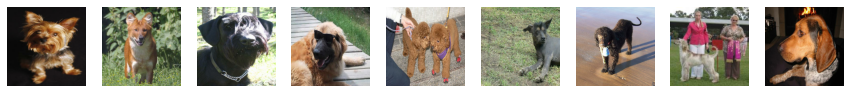

In [10]:
image_list = []
for image, label in train.take(9):
    image_list.append(image)
display(image_list)

In [20]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.compat.v1.Session(config=config)

In [12]:
IMG_SHAPE = (256, 256, 3)
NUM_CLASSES = 120

In [13]:
model = My_CNN().create_model(IMG_SHAPE, NUM_CLASSES)

build model


In [15]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [16]:
VAL_SUBSPLITS = 5
VALIDATION_STEPS = metadata.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
TRAIN_LENGTH = metadata.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


In [21]:
history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=50, 
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=test_dataset, 
          validation_steps=VALIDATION_STEPS, shuffle=True)
model.evaluate(test_dataset)

Epoch 1/50
  2/187 [..............................] - ETA: 21s - loss: 4.8085 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0688s vs `on_train_batch_end` time: 0.1516s). Check your callbacks.


187/187 [==============================] - 43s 232ms/step - loss: 4.7885 - accuracy: 0.0068 - val_loss: 4.7875 - val_accuracy: 0.0072
Epoch 2/50
187/187 [==============================] - 43s 229ms/step - loss: 4.7879 - accuracy: 0.0068 - val_loss: 4.7875 - val_accuracy: 0.0054
Epoch 3/50
187/187 [==============================] - 42s 226ms/step - loss: 4.7878 - accuracy: 0.0072 - val_loss: 4.7873 - val_accuracy: 0.0072
Epoch 4/50
187/187 [==============================] - 42s 226ms/step - loss: 4.7868 - accuracy: 0.0090 - val_loss: 4.7822 - val_accuracy: 0.0180
Epoch 5/50
187/187 [==============================] - 42s 227ms/step - loss: 4.7813 - accuracy: 0.0122 - val_loss: 4.7687 - val_accuracy: 0.0246
Epoch 6/50
187/187 [==============================] - 42s 227ms/step - loss: 4.7647 - accuracy: 0.0135 - val_loss: 4.7318 - val_accuracy: 0.0282
Epoch 7/50
187/187 [==============================] - 42s 227ms/step - loss: 4.7374 - accuracy: 0.0145 - val_loss: 4.7002 - val_accuracy: 0.0

KeyboardInterrupt: 

После 30 эпох обучения мы получили точность на тренировочных данных порядка 0.9, однако на валидационной выборке, точность достигала всего 0.06. По всей видмости, данная архитектура слишкам проста, чтобы классифицировать 120 различных классов.